## Transient Universe Nested sampling


In [2]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

from sklearn.neighbors import KernelDensity

import emcee
import pymc3
import corner

import dynesty
from dynesty import plotting as dyplot

### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**

1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

Text(0.5, 1.0, 'Transient flux')

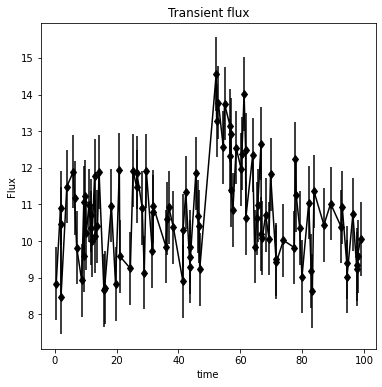

In [3]:
file = np.load('transient.npy')

time = file[:,0]
flux = file[:,1]
err_flux = file[:,2]

fig = plt.figure(figsize=(6,6))

#plt.plot(time,flux,c='black')
#plt.scatter(time,flux,c='black',s=10)
plt.errorbar(time,flux,err_flux,c='black',marker='d')
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Transient flux')

### Burst model

In [4]:
# burst model:
def burst_model(params,t):
    '''burst model for the transient flux'''
    # extract the parameters
    t0 = params[0]
    b = params[1]
    A = params[2]
    alpha = params[3]
    
    # define the model
    func = np.zeros(len(t))
    
    for i in range(len(t)):
        if(t[i]<t0):
            func[i] = b
        elif(t[i]>=t0):
             func[i] = b + A*np.exp(-alpha*(t[i]-t0))
        
    return func

# prior
def prior_trans(params):
    prior_t0 = scipy.stats.uniform(30,70).ppf(params[0])
    prior_b = scipy.stats.uniform(0,20).ppf(params[1])
    prior_A = scipy.stats.uniform(0,20).ppf(params[2])
    prior_Alpha = scipy.stats.uniform(np.exp(-5),np.exp(2)).ppf(params[3])
    
    if not np.isfinite(np.array([prior_t0,prior_b,prior_A,prior_Alpha]).any()):
        return -np.inf
    else:
        return np.array([prior_t0,prior_b,prior_A,prior_Alpha])
    

# log-Likelihood:
def logL(params):
    """Gaussian log-likelihood of the model"""
    model=burst_model
    
    # load the data
    x,y,err_y = np.array([time,flux,err_flux])
    
    # apply the model
    y_fit = model(params,x)
    
    #print(params)
    #logL_vector.append(sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y)))
    
    return sum(-np.log(np.sqrt(2*np.pi)*args[2]) + scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y))


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.



In [5]:
# "Static" nested sampling.
ndim = 4

sampler_burst = dynesty.NestedSampler(logL, prior_trans, ndim)
sampler_burst.run_nested()
sresults_burst = sampler_burst.results

7521it [30:28,  4.11it/s, +500 | bound: 112 | nc: 1 | ncall: 106921 | eff(%):  7.537 | loglstar:   -inf < -232.541 <    inf | logz: -246.802 +/-  0.166 | dlogz:  0.001 >  0.509]


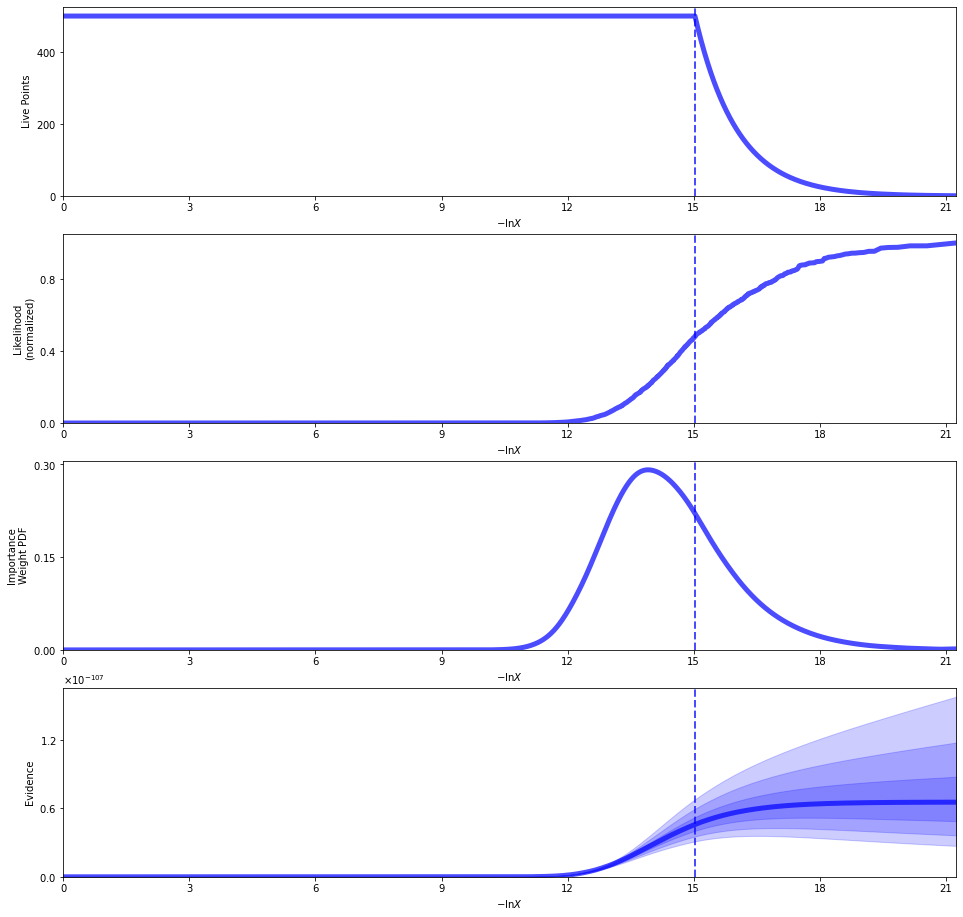

In [6]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(sresults_burst)

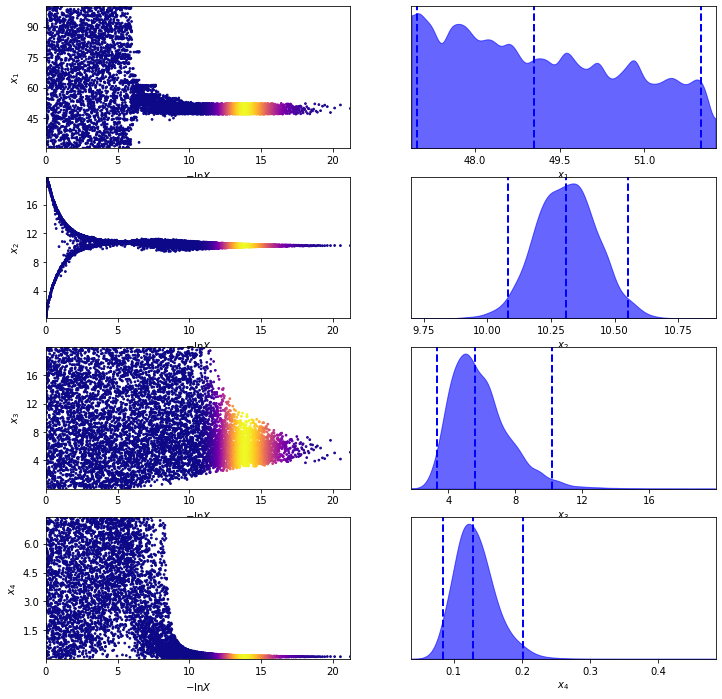

In [7]:
tfig, taxes = dyplot.traceplot(sresults_burst)

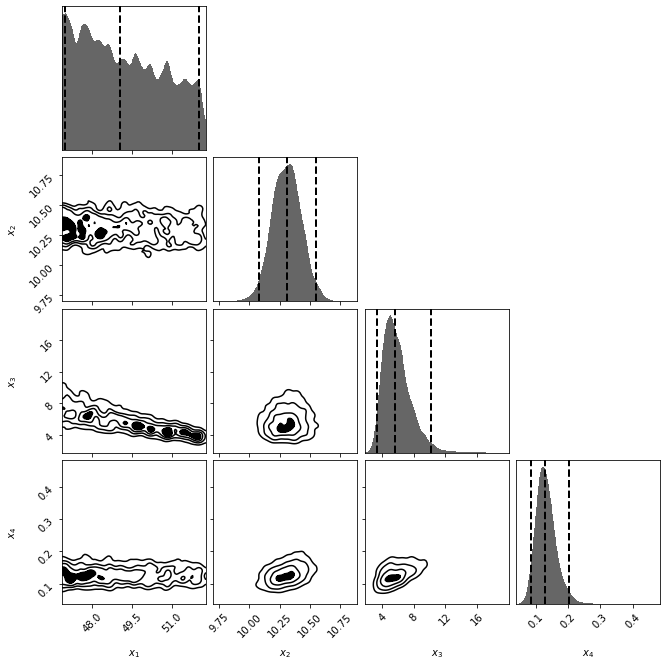

In [8]:
cfig, caxes = dyplot.cornerplot(sresults_burst)

### Gaussian model

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)


In [9]:
# burst model:
def Gauss_model(params,t):
    '''burst model for the transient flux'''
    # extract the parameters
    t0 = params[0]
    b = params[1]
    A = params[2]
    sigma_w = params[3]
    
    # define the model
    func = np.zeros(len(t))
    
    for i in range(len(t)):
        if(t[i]<t0):
            func[i] = b
        elif(t[i]>=t0):
             func[i] = b + A*np.exp(-(t[i]-t0)**2/(2*sigma_w**2))
        
    return func

# prior
def prior_trans(params):
    prior_t0 = scipy.stats.uniform(30,70).ppf(params[0])
    prior_b = scipy.stats.uniform(0,20).ppf(params[1])
    prior_A = scipy.stats.uniform(0,20).ppf(params[2])
    prior_sigmaw = scipy.stats.uniform(0,100).ppf(params[3])
    
    if not np.isfinite(np.array([prior_t0,prior_b,prior_A,prior_sigmaw]).any()):
        return -np.inf
    else:
        return np.array([prior_t0,prior_b,prior_A,prior_sigmaw])
    

# log-Likelihood:
def logL(params):
    """Gaussian log-likelihood of the model"""
    model=Gauss_model
    
    # load the data
    x,y,err_y = np.array([time,flux,err_flux])
    
    # apply the model
    y_fit = model(params,x)
    
    #print(params)
    #logL_vector.append(sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y)))
    
    return sum(-np.log(np.sqrt(2*np.pi)*args[2]) + scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y))

In [10]:
# "Static" nested sampling.
ndim = 4

sampler_gauss = dynesty.NestedSampler(logL, prior_trans, ndim)
sampler_gauss.run_nested()
sresults_gauss = sampler_gauss.results

7221it [24:10,  4.98it/s, +500 | bound: 88 | nc: 1 | ncall: 87847 | eff(%):  8.839 | loglstar:   -inf < -232.129 <    inf | logz: -245.800 +/-  0.162 | dlogz:  0.001 >  0.509]


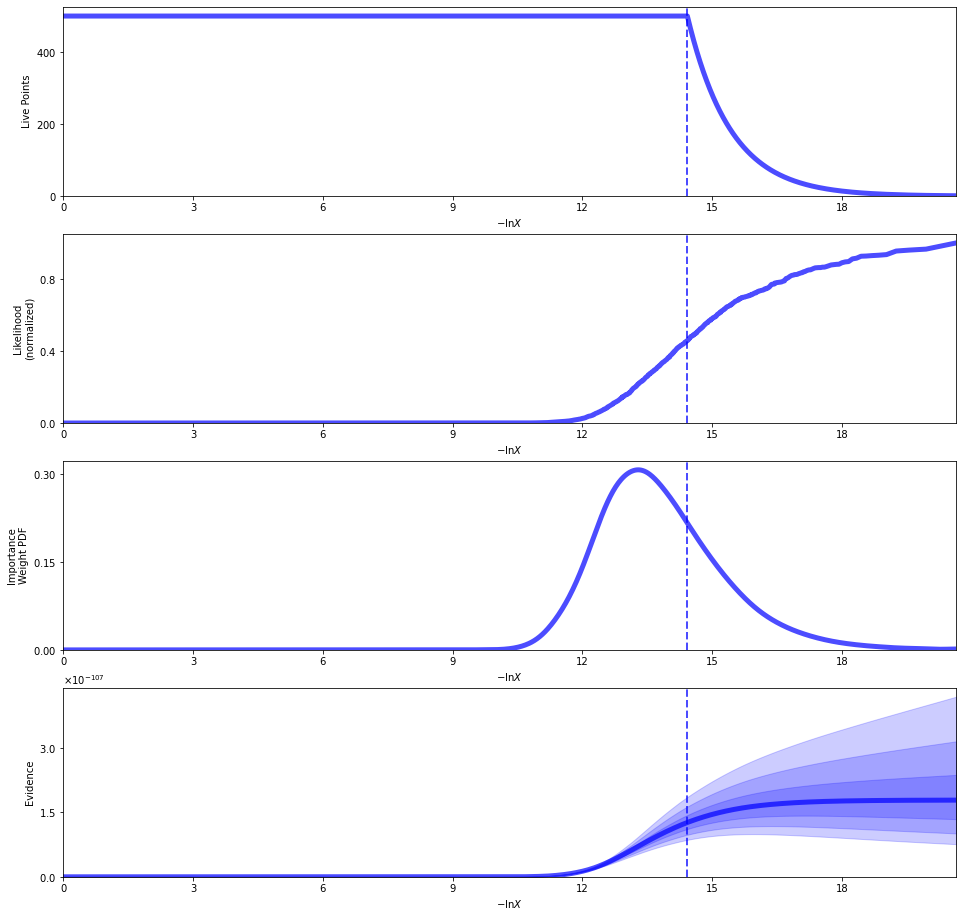

In [11]:
rfig, raxes = dyplot.runplot(sresults_gauss)

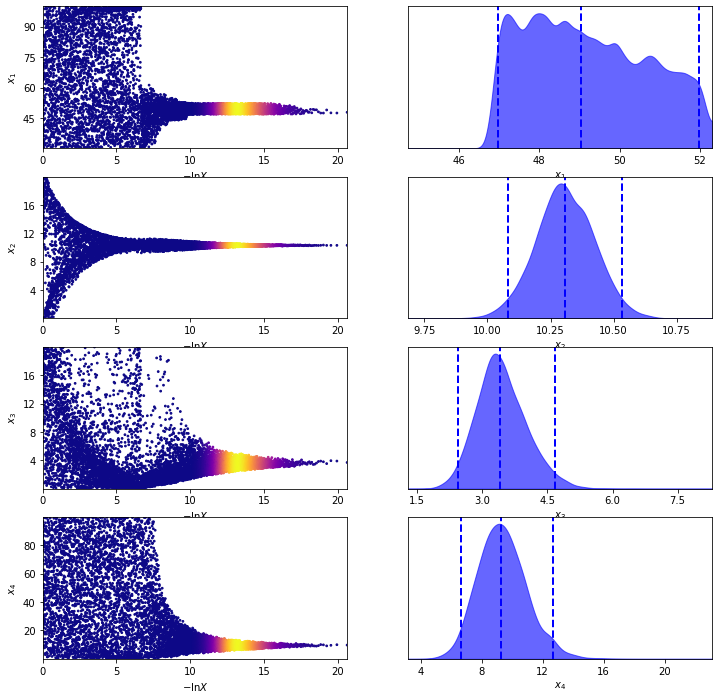

In [12]:
tfig, taxes = dyplot.traceplot(sresults_gauss)

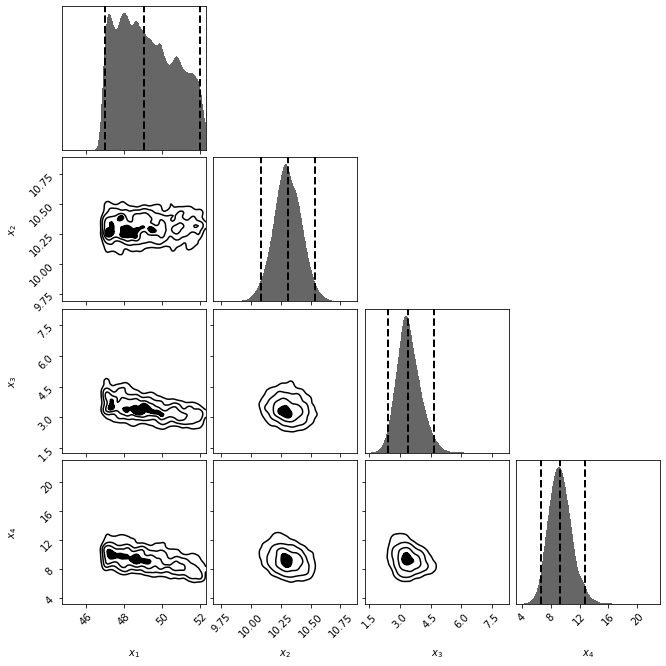

In [13]:
cfig, caxes = dyplot.cornerplot(sresults_gauss)


9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

### Burst Bayesan evidence and results

In [14]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples_burst = sresults_burst.samples
weights_burst = np.exp(sresults_burst.logwt - sresults_burst.logz[-1])  # normalized weights

evidence_burst = sresults_burst.logz[-1] #evidence
print("Bayesian evidence for burst model", np.exp(evidence_burst))

# Compute 10%-90% quantiles.
quantiles_burst = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_burst)
             for samps in samples_burst.T]
print('68% parameter credible regions are:\n ' + str(quantiles_burst) + '\n')

# Compute weighted mean and covariance.
mean_burst, cov_burst = dyfunc.mean_and_cov(samples_burst, weights_burst)
print('Mean and covariance of parameters for the burst model are: \n\n' + str(mean_burst) + '\n\n' + str(cov_burst))

Bayesian evidence for burst model 6.537147607783532e-108
68% parameter credible regions are:
 [[47.51645972643977, 51.02031701295592], [10.1930799900076, 10.43141416564323], [4.245425238725752, 7.538029129080098], [0.10258674022721308, 0.15904782445510687]]

Mean and covariance of parameters for the burst model are: 

[49.20234097 10.31077888  5.88858064  0.13142683]

[[ 2.33562027e+00 -7.78237459e-03 -1.81447494e+00 -8.61677538e-04]
 [-7.78237459e-03  1.44820543e-02  2.13790777e-02  1.45559556e-03]
 [-1.81447494e+00  2.13790777e-02  3.10573756e+00  3.02722237e-02]
 [-8.61677538e-04  1.45559556e-03  3.02722237e-02  9.03313641e-04]]


### Gauss Bayesan evidence and results

In [15]:
# Extract sampling results.
samples_gauss = sresults_gauss.samples
weights_gauss = np.exp(sresults_gauss.logwt - sresults_gauss.logz[-1])  # normalized weights

evidence_gauss = sresults_gauss.logz[-1] #evidence
print("Bayesian evidence for gauss model", np.exp(evidence_gauss))

# Compute 10%-90% quantiles.
quantiles_gauss = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_gauss)
             for samps in samples_gauss.T]
print('68% parameter credible regions are:\n ' + str(quantiles_gauss) + '\n')

# Compute weighted mean and covariance.
mean_gauss, cov_gauss = dyfunc.mean_and_cov(samples_gauss, weights_gauss)
print('Mean and covariance of parameters for the gauss model are: \n\n' + str(mean_gauss) + '\n\n' + str(cov_gauss))

Bayesian evidence for gauss model 1.7806800296610627e-107
68% parameter credible regions are:
 [[47.54210872731858, 50.9769198282574], [10.195323717595153, 10.422052147214407], [2.8924473528305246, 3.9990650953427616], [7.798821964185383, 10.850320213556836]]

Mean and covariance of parameters for the gauss model are: 

[49.2088023  10.30710317  3.44041023  9.35227103]

[[ 2.20812118  0.00534436 -0.37136974 -0.99831157]
 [ 0.00534436  0.01327396 -0.00924919 -0.05074137]
 [-0.37136974 -0.00924919  0.32216478 -0.28191351]
 [-0.99831157 -0.05074137 -0.28191351  2.51195939]]
